# Equity Market Crisis Regime Prediction using Machine Learning GBDT

## Part VIII: Deployment: end-to-end process (LightGBM)

### Quick access to the whole series:

1. [Part I: Introduction](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt1)
1. [Part II: Data Preparation](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt2)
1. [Part III: Exploratory data analysis](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt3)
1. [Part IV: Feature Selection, Hyperparameter Tuning (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt4)
1. [Part V: Model Evaluation and Interpretation (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt5)
1. [Part VI: SVM and Neural Networks (MLP and 1D-CNN)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt6)
1. [Part VII: Compare GBDT Models: XGBoost and LightGBM](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt7)
1. [Part VIII: Deployment: end-to-end process (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt8)

---

### █ This notebook is scheduled to run daily to produce the crisis regime prediction. █ 

---


### Outline of this notebook

<a id='toc'></a>

[0. Prep: install and load packages](#0)

[1. Download data from yfinance and stlouisfed via API](#1)
 
 - [1.1 Download data from yfinance](#1.1)
 - [1.2 Engineer target variable](#1.2)
 - [1.3 Download data from fred.stlouisfed.org](#1.3)
 - [1.4 Process stlouisfed data: convert non-daily to daily, shift data by update date](#1.4)
 - [1.5 Combine target variable, yfinance data, and fred.stlouisfed.org data](#1.5)
 - [1.6 Impute missing values](#1.6)
 
[2. Feature engineering](#2)

[3. Train LightGBM models](#3)

[4. Predict](#4)


<a id="0"></a>

# <left>0. Prep: install and load packages</left>

[back to top](#toc)


In [1]:
import pandas as pd
import numpy as np
import os
import gc
import copy
from pathlib import Path
from datetime import datetime, timedelta, date
import time
from dateutil.relativedelta import relativedelta 

import pyarrow.parquet as pq
import pyarrow as pa

from tqdm import tqdm

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
random_seed=1
pl.seed_everything(random_seed)

1

In [3]:
!pip install mplfinance==0.12.9b1
!pip install yfinance==0.1.66
!pip install fredapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 266.2 kB/s eta 0:00:00




<a id="1"></a>

# <left>1. Download data from yfinance and stlouisfed via API</left>

[back to top](#toc)

In [4]:
final_feats = ['NASDAQ100_std125_chg200', 'MICH_ma_dist20_50', 'STLPPM_ma_dist20_50', 'GC=F_chg5', 'STLFSI3_pct_chg5', 'VIXCLS_chg20', 'VIX_zscore250', 'IRLTLT01JPM156N_std125', 'LFWA64TTJPM647S_volat60', 'WILLLRGCAPVAL_std60_chg200', 'GC=F_pct_chg20_above200dMA', 'PAYNSA_zscore200', 'T1YFF_pct_chg20', 'NIKKEI225_zscore120', 'LRUN64TTJPM156S_std125_chg200', 'T1YFF_ma_dist200_50', 'WILLSMLCAP_chg20', 'HSI_chg5', 'JPNASSETS_zscore120', 'NIKKEI225_std60_chg200', 'HSI_chg20', 'N225_pct_chg20', 'FVX_chg5', 'NASDAQ100_pct_chg10', 'RBJPBIS_ma_dist20_50', 'KS11_pct_chg5', 'WILLSMLCAP_chg10', 'T10Y2Y_pct_chg120', 'JTSOSL_std60_chg200', 'BAMLHYH0A0HYM2TRIV_std125_chg200', 'IRLTLT01JPM156N_std60_chg200', 'TB3SMFFM_zscore200', 'NIKKEI225_pct_chg10', 'RBJPBIS_zscore60', 'WILLREITIND_ma_dist20_50', 'LRUN64TTJPM156S_pct_chg250', 'MICH_pct_chg5', 'TNX_mean_std120', 'BAMLHE00EHYITRIV_chg10', 'VXNCLS_mean_std120', 'MYAGM2JPM189S_std125', 'BAA10YM_zscore120', 'T10Y3M_chg250', 'MYAGM2JPM189S_chg20', 'EXPINF1YR_chg5_above200dMA', 'NFCICREDIT_pct_chg60', 'GC=F_pct_chg10', 'REAINTRATREARAT1YE_pct_chg120', 'NDX_chg120', 'GVZCLS_chg5', 'KCFSI_chg20', 'AAA10Y_pct_chg5', 'TENEXPCHAINFRISPRE_ma_dist20_50', 'T5YIEM_pct_chg20', 'BAMLHE00EHYITRIV_chg5', 'USSLIND_pct_chg120', 'FVX_pct_chg10', 'T10YIEM_chg60', 'WILLREITIND_pct_chg20', 'BAA10Y_pct_chg10', 'T10YFF_chg10', 'LFWA64TTJPM647S_chg60', 'OVXCLS_volat60', 'RUT_pct_chg10', 'VXNCLS_chg10', 'BAA10Y_zscore250', 'NDX_chg10', 'T10Y2YM_zscore250', 'JPNASSETS', 'CPFF_pct_chg10', 'WILLREITIND_chg20', 'TNX_chg20', 'IRSTCI01JPM156N_chg20', 'GC=F_zscore60', 'CPFF_pct_chg250', 'CPFF_chg5', 'BAMLHYH0A3CMTRIV_chg10', 'CPFF_pct_chg5', 'VXNCLS_chg5', 'GC=F_chg20', 'FVX_pct_chg5', 'T10Y2Y_pct_chg250', 'FTSE_chg10', 'N100_std60_chg200', 'HSI_zscore60', 'NFCIRISK_pct_chg60', 'STLFSI3_pct_chg60', 'VIX_pct_chg10', 'RVXCLS_chg10', 'NFCICREDIT_pct_chg5', 'STLPPM_chg5', 'T3MFF_zscore60', 'ABCOMP_chg5', 'T10Y3M_pct_chg250', 'ABCOMP_pct_chg5', 'USSLIND_pct_chg20', 'STLPPM_pct_chg5', 'T3MFF_chg10', 'FVX_zscore200', 'VXDCLS_chg5', 'VIX_zscore60', 'VIX_chg20', 'STOXX50E_pct_chg10', 'DJI_zscore120', 'STLFSI3_chg5', 'NFCICREDIT', 'T10YIEM_pct_chg60', 'NDX_zscore60', 'HSI_chg10', 'AAAFF_pct_chg5', 'FTSE_mean_std120', 'MYAGM2JPM189S_chg5', 'BAMLHE00EHYITRIV_pct_chg250', 'REAINTRATREARAT1MO_ma_dist500_250', 'CPFF_pct_chg20', 'VXDCLS_pct_chg10', 'BAMLHYH0A3CMTRIV_zscore120', 'NFCI_chg5', 'FTSE_chg20', 'FVX_ma_dist20_50', 'T10YFF_pct_chg20', 'NFCILEVERAGE_chg250', 'BAMLHYH0A0HYM2TRIV_pct_chg10', 'T10Y2YM_std125_chg200', 'CFNAIDIFF_std60', 'N100_zscore120', 'DJI_chg10']

print(final_feats)
print(len(final_feats))

['NASDAQ100_std125_chg200', 'MICH_ma_dist20_50', 'STLPPM_ma_dist20_50', 'GC=F_chg5', 'STLFSI3_pct_chg5', 'VIXCLS_chg20', 'VIX_zscore250', 'IRLTLT01JPM156N_std125', 'LFWA64TTJPM647S_volat60', 'WILLLRGCAPVAL_std60_chg200', 'GC=F_pct_chg20_above200dMA', 'PAYNSA_zscore200', 'T1YFF_pct_chg20', 'NIKKEI225_zscore120', 'LRUN64TTJPM156S_std125_chg200', 'T1YFF_ma_dist200_50', 'WILLSMLCAP_chg20', 'HSI_chg5', 'JPNASSETS_zscore120', 'NIKKEI225_std60_chg200', 'HSI_chg20', 'N225_pct_chg20', 'FVX_chg5', 'NASDAQ100_pct_chg10', 'RBJPBIS_ma_dist20_50', 'KS11_pct_chg5', 'WILLSMLCAP_chg10', 'T10Y2Y_pct_chg120', 'JTSOSL_std60_chg200', 'BAMLHYH0A0HYM2TRIV_std125_chg200', 'IRLTLT01JPM156N_std60_chg200', 'TB3SMFFM_zscore200', 'NIKKEI225_pct_chg10', 'RBJPBIS_zscore60', 'WILLREITIND_ma_dist20_50', 'LRUN64TTJPM156S_pct_chg250', 'MICH_pct_chg5', 'TNX_mean_std120', 'BAMLHE00EHYITRIV_chg10', 'VXNCLS_mean_std120', 'MYAGM2JPM189S_std125', 'BAA10YM_zscore120', 'T10Y3M_chg250', 'MYAGM2JPM189S_chg20', 'EXPINF1YR_chg5_abo

In [5]:
raw_feats = []
for feat in final_feats:
    raw_feats.append(feat.split('_')[0])
    
raw_feats = list(set(raw_feats))

In [6]:
print(len(raw_feats), raw_feats)

65 ['IRLTLT01JPM156N', 'TB3SMFFM', 'PAYNSA', 'AAA10Y', 'NIKKEI225', 'NASDAQ100', 'REAINTRATREARAT1YE', 'RBJPBIS', 'N225', 'T10YIEM', 'FVX', 'T10Y2Y', 'T10YFF', 'NFCILEVERAGE', 'STOXX50E', 'KS11', 'BAA10YM', 'VIX', 'WILLLRGCAPVAL', 'TENEXPCHAINFRISPRE', 'VIXCLS', 'ABCOMP', 'WILLREITIND', 'RUT', 'JTSOSL', 'JPNASSETS', 'VXDCLS', 'CFNAIDIFF', 'VXNCLS', 'OVXCLS', 'N100', 'STLFSI3', 'KCFSI', 'MICH', 'LFWA64TTJPM647S', 'USSLIND', 'BAMLHYH0A3CMTRIV', 'REAINTRATREARAT1MO', 'NFCI', 'NFCICREDIT', 'EXPINF1YR', 'STLPPM', 'NDX', 'T1YFF', 'LRUN64TTJPM156S', 'BAMLHE00EHYITRIV', 'T5YIEM', 'CPFF', 'GVZCLS', 'BAA10Y', 'GC=F', 'T10Y2YM', 'TNX', 'AAAFF', 'BAMLHYH0A0HYM2TRIV', 'IRSTCI01JPM156N', 'HSI', 'NFCIRISK', 'T10Y3M', 'MYAGM2JPM189S', 'RVXCLS', 'FTSE', 'DJI', 'T3MFF', 'WILLSMLCAP']


In [7]:
#https://sg.finance.yahoo.com/world-indices/
#https://sg.finance.yahoo.com/bonds/
#https://sg.finance.yahoo.com/commodities/
benchmark_tickers = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^VIX', 
                     '^TYX', '^TNX','^FVX', '^IRX','^NDX', 'DX-Y.NYB',  'EEM','IEMG','^FTSE','^STOXX50E',
                     '^N225', 'JPY=X', '^KS11', 'GC=F', 'CL=F', '^HSI', '^KLSE', '^N100'
                    ]#'^SPX'

In [8]:
yfinance_tickers = ['^GSPC']
fed_tickers = []
for f in raw_feats:
    if (f'^{f}' in benchmark_tickers):
        yfinance_tickers.append(f'^{f}')
    elif (f'{f}' in benchmark_tickers):
        yfinance_tickers.append(f'{f}')
    else:
        fed_tickers.append(f)
        
print(yfinance_tickers)
print(fed_tickers)

['^GSPC', '^N225', '^FVX', '^STOXX50E', '^KS11', '^VIX', '^RUT', '^N100', '^NDX', 'GC=F', '^TNX', '^HSI', '^FTSE', '^DJI']
['IRLTLT01JPM156N', 'TB3SMFFM', 'PAYNSA', 'AAA10Y', 'NIKKEI225', 'NASDAQ100', 'REAINTRATREARAT1YE', 'RBJPBIS', 'T10YIEM', 'T10Y2Y', 'T10YFF', 'NFCILEVERAGE', 'BAA10YM', 'WILLLRGCAPVAL', 'TENEXPCHAINFRISPRE', 'VIXCLS', 'ABCOMP', 'WILLREITIND', 'JTSOSL', 'JPNASSETS', 'VXDCLS', 'CFNAIDIFF', 'VXNCLS', 'OVXCLS', 'STLFSI3', 'KCFSI', 'MICH', 'LFWA64TTJPM647S', 'USSLIND', 'BAMLHYH0A3CMTRIV', 'REAINTRATREARAT1MO', 'NFCI', 'NFCICREDIT', 'EXPINF1YR', 'STLPPM', 'T1YFF', 'LRUN64TTJPM156S', 'BAMLHE00EHYITRIV', 'T5YIEM', 'CPFF', 'GVZCLS', 'BAA10Y', 'T10Y2YM', 'AAAFF', 'BAMLHYH0A0HYM2TRIV', 'IRSTCI01JPM156N', 'NFCIRISK', 'T10Y3M', 'MYAGM2JPM189S', 'RVXCLS', 'T3MFF', 'WILLSMLCAP']


<a id="1.1"></a>

## <left>1.1 Download data from yfinance</left>


[back to top](#toc)


In [9]:
import yfinance as yf

In [10]:
#https://github.com/ranaroussi/yfinance/blob/main/yfinance/base.py
#     def history(self, period="1mo", interval="1d",
#                 start=None, end=None, prepost=False, actions=True,
#                 auto_adjust=True, back_adjust=False,
#                 proxy=None, rounding=False, tz=None, timeout=None, **kwargs):

dfs = {}

for ticker in  yfinance_tickers:
    cur_data = yf.Ticker(ticker)
    hist = cur_data.history(period="max")
    print(ticker, cur_data.info['shortName'], datetime.now(), ticker, hist.shape, hist.index.min(), hist.index.max())

    dfs[ticker] = hist
    


^GSPC S&P 500 2022-10-09 23:40:29.137319 ^GSPC (18311, 7) 1950-01-03 00:00:00 2022-10-07 00:00:00
^N225 Nikkei 225 2022-10-09 23:40:39.362469 ^N225 (14205, 7) 1965-01-05 00:00:00 2022-10-07 00:00:00
^FVX Treasury Yield 5 Years 2022-10-09 23:40:49.445964 ^FVX (15204, 7) 1962-01-02 00:00:00 2022-10-07 00:00:00
^STOXX50E ESTX 50 PR.EUR 2022-10-09 23:40:58.826143 ^STOXX50E (3892, 7) 2007-03-30 00:00:00 2022-10-07 00:00:00
^KS11 KOSPI Composite Index 2022-10-09 23:41:09.243587 ^KS11 (6364, 7) 1996-12-11 00:00:00 2022-10-07 00:00:00
^VIX CBOE Volatility Index 2022-10-09 23:41:18.936160 ^VIX (8257, 7) 1990-01-02 00:00:00 2022-10-07 00:00:00
^RUT Russell 2000 2022-10-09 23:41:29.732809 ^RUT (8841, 7) 1987-09-10 00:00:00 2022-10-07 00:00:00
^N100 Euronext 100 Index 2022-10-09 23:41:39.291650 ^N100 (5824, 7) 1999-12-31 00:00:00 2022-10-07 00:00:00
^NDX NASDAQ 100 2022-10-09 23:41:48.867650 ^NDX (9332, 7) 1985-10-01 00:00:00 2022-10-07 00:00:00
GC=F Gold Dec 22 2022-10-09 23:41:59.084350 GC=F (55

<a id="1.2"></a>

## <left>1.2 Download data from yfinance</left>


[back to top](#toc)


In [11]:
df_target = dfs['^GSPC'].copy(deep=True)


In [12]:
#15day_pct change
df_target['pct_chg15'] = df_target['Close'].pct_change(15)
df_target['regime_change'] = df_target['pct_chg15'].rolling(window=5000, min_periods=2000).apply(lambda x:x[:-1].quantile(q=0.05)>x[-1])
#in the papers, the authors did not describe shifting the target. 
#here shift the target by n days to use X on d0 to predict if there will be a crisis regime in n days
df_target['target'] = df_target['regime_change'].shift(-3)

<AxesSubplot:xlabel='Date'>

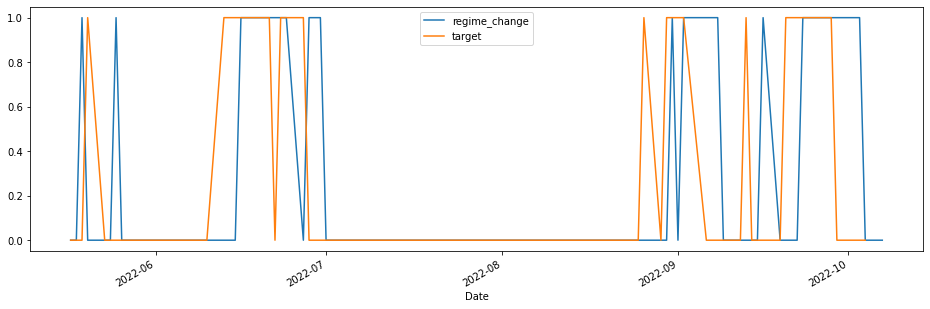

In [13]:
df_target[['regime_change', 'target']].tail(100).plot(figsize=(16, 5))

In [14]:
max_date = df_target.index.max()
max_date

Timestamp('2022-10-07 00:00:00')

<a id="1.3"></a>

## <left>1.3 Download data from [fred.stlouisfed.org](https://fred.stlouisfed.org/)</left>

[back to top](#toc)



In [15]:
# https://www.multpl.com/s-p-500-dividend-yield/table/by-month
# https://www.multpl.com/s-p-500-earnings
# https://www.multpl.com/s-p-500-pe-ratio/table/by-month
# https://www.multpl.com/shiller-pe/table/by-year
#https://fred.stlouisfed.org/categories/46

#https://fredaccount.stlouisfed.org/apikeys
#https://mortada.net/python-api-for-fred.html
#https://github.com/mortada/fredapi
#https://www.briancjenkins.com/fredpy/docs/build/html/fredpy_examples.html
from fredapi import Fred
fred = Fred('c8d4f8e608b42f6d85dd037f2080e451')

In [16]:
dir(fred)

['_Fred__do_series_search',
 '_Fred__fetch_data',
 '_Fred__get_search_results',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_parse',
 'api_key',
 'earliest_realtime_start',
 'get_series',
 'get_series_all_releases',
 'get_series_as_of_date',
 'get_series_first_release',
 'get_series_info',
 'get_series_latest_release',
 'get_series_vintage_dates',
 'latest_realtime_end',
 'max_results_per_request',
 'nan_char',
 'root_url',
 'search',
 'search_by_category',
 'search_by_release']

In [17]:
help(fred.get_series)

Help on method get_series in module fredapi.fred:

get_series(series_id, observation_start=None, observation_end=None, **kwargs) method of fredapi.fred.Fred instance
    Get data for a Fred series id. This fetches the latest known data, and is equivalent to get_series_latest_release()
    
    Parameters
    ----------
    series_id : str
        Fred series id such as 'CPIAUCSL'
    observation_start : datetime or datetime-like str such as '7/1/2014', optional
        earliest observation date
    observation_end : datetime or datetime-like str such as '7/1/2014', optional
        latest observation date
    kwargs : additional parameters
        Any additional parameters supported by FRED. You can see https://api.stlouisfed.org/docs/fred/series_observations.html for the full list
    
    Returns
    -------
    data : Series
        a Series where each index is the observation date and the value is the data for the Fred series



In [18]:
%%time
desc_dfs = []
for series_id in tqdm(fed_tickers):
    desc_dfs.append(fred.get_series_info(series_id))
    

100%|██████████| 52/52 [00:52<00:00,  1.01s/it]

CPU times: user 739 ms, sys: 57.7 ms, total: 797 ms
Wall time: 52.4 s


In [19]:
df_desc = pd.concat(desc_dfs, axis=1).T
df_desc['popularity'] = df_desc['popularity'].astype(int)
df_desc['discontinued'] = df_desc['title'].apply(lambda x: 'DISCONTINUED' in x)
df_desc.sort_values(by='popularity', ascending=False, inplace=True)

In [20]:
df_desc.index=df_desc['id']
df_desc.index.name='series_id'

df_desc['last_updated'] = pd.to_datetime(df_desc['last_updated'].values)

# !!!! Make sure all the fed_tickers can be retrieved via API

- this is validated by comparing `df_desc.shape[0]` and `len(fed_tickers)`

In [21]:
df_desc.shape, len(fed_tickers)

((52, 16), 52)

In [22]:
df_desc

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes,discontinued
series_id,,,,,,,,,,,,,,,,
T10Y2Y,T10Y2Y,2022-10-09,2022-10-09,10-Year Treasury Constant Maturity Minus 2-Yea...,1976-06-01,2022-10-07,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-07 16:01:02-05:00,100,"Starting with the update on June 21, 2019, the...",False
T10Y3M,T10Y3M,2022-10-09,2022-10-09,10-Year Treasury Constant Maturity Minus 3-Mon...,1982-01-04,2022-10-07,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-07 16:01:02-05:00,93,Series is calculated as the spread between 10-...,False
VIXCLS,VIXCLS,2022-10-09,2022-10-09,CBOE Volatility Index: VIX,1990-01-02,2022-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-07 08:36:04-05:00,77,VIX measures market expectation of near term v...,False
BAA10Y,BAA10Y,2022-10-09,2022-10-09,Moody's Seasoned Baa Corporate Bond Yield Rela...,1986-01-02,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-07 16:02:02-05:00,77,Series is calculated as the spread between Moo...,False
MICH,MICH,2022-10-09,2022-10-09,University of Michigan: Inflation Expectation,1978-01-01,2022-08-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-09-30 10:01:01-05:00,76,"Median expected price change next 12 months, S...",False
NFCI,NFCI,2022-10-09,2022-10-09,Chicago Fed National Financial Conditions Index,1971-01-08,2022-09-30,"Weekly, Ending Friday",W,Index,Index,Not Seasonally Adjusted,NSA,2022-10-05 07:33:03-05:00,76,The Chicago Fed's National Financial Condition...,False
T10YFF,T10YFF,2022-10-09,2022-10-09,10-Year Treasury Constant Maturity Minus Feder...,1962-01-02,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-07 16:01:03-05:00,74,Series is calculated as the spread between 10-...,False
AAA10Y,AAA10Y,2022-10-09,2022-10-09,Moody's Seasoned Aaa Corporate Bond Yield Rela...,1983-01-03,2022-10-06,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-07 16:02:03-05:00,69,Series is calculated as the spread between Moo...,False
STLFSI3,STLFSI3,2022-10-09,2022-10-09,St. Louis Fed Financial Stress Index,1993-12-31,2022-09-30,"Weekly, Ending Friday",W,Index,Index,Not Seasonally Adjusted,NSA,2022-10-06 09:00:03-05:00,68,The STLFSI3 measures the degree of financial s...,False


# !!!! Pay attention to discontinued datasets

In [23]:

df_desc['discontinued'].sum()

0

<a id="1.4"></a>

## <left>1.4 Process stlouisfed data</left>


[back to top](#toc)


In [24]:
df_desc['frequency'].value_counts()

Monthly                     22
Daily, Close                14
Daily                        9
Weekly, Ending Friday        5
Monthly, End of Period       1
Weekly, Ending Wednesday     1
Name: frequency, dtype: int64

In [25]:
df_desc['frequency_short'].value_counts()

D    23
M    23
W     6
Name: frequency_short, dtype: int64

In [26]:
start_date = '2000-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
end_date

'2022-10-09'

In [27]:
%%time
fed_data_dict = {}
for series_id, row in df_desc.iterrows():
    data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
    fed_data_dict[series_id] = data
    

CPU times: user 17.5 s, sys: 163 ms, total: 17.6 s
Wall time: 1min 38s


#### Process data

For `Today`:  Grab data - most recent data will be yesterday's data updated at day-end - to predict if crisis regime is going to happen in ? days

- For `daily` frequency data: check the difference (in days) between last_updated and max_date (from target data), and make the x_date shift by n
    - if n<1, day-end update. x_date is the date 
    - if n>=1: shift 
- For `weekly` and `monthly` data:
    - convert to daily
    - shift the date to update date

In [28]:
fed_dfs = {}
for series_id, data in fed_data_dict.items():
    row = df_desc.loc[series_id]
    #n_diff = (datetime.now(tz=row['last_updated'].tzinfo) - row['last_updated']).days
    #n_diff = (max_date - datetime.strptime(row['last_updated'].strftime('%Y-%m-%d'),'%Y-%m-%d')).days
    
    #process daily data
    if row['frequency_short']=='D': 
        n_diff = (max_date - datetime.strptime(data.index.max().strftime('%Y-%m-%d'),'%Y-%m-%d')).days
        data.index.name='date'
        data.name=series_id
        data = data.to_frame().reset_index()
        print(row['frequency_short'],series_id, row['last_updated'], n_diff)
        
        if n_diff<1:
            data['x_date'] = data['date']
        else:
            #data['x_date'] = data['date'].shift(-n_diff)
            data['x_date'] = data['date'].shift(-n_diff).tolist()[:-n_diff] + df_target.index[-n_diff:].tolist()
        fed_dfs[series_id] = data
    else: #monthly/weekly data
        data.index.name='date'
        data.name=series_id
        data = data.to_frame().reset_index()
        
        n_diff = (datetime.strptime(row['last_updated'].strftime('%Y-%m-%d'),'%Y-%m-%d') - data['date'].max()).days 
        data['x_date'] = data['date'].apply(lambda x: x+relativedelta(days=n_diff))
        
        data_ = pd.DataFrame({'x_date':pd.date_range(start=data['x_date'].min(), end=data['x_date'].max(), freq='D')})
        data_ = data_.merge(data,  on='x_date', how='left')
        data_.fillna(method='ffill', inplace=True)
        
        print(row['frequency_short'],series_id, row['last_updated'], n_diff)
        fed_dfs[series_id] = data_

D T10Y2Y 2022-10-07 16:01:02-05:00 0
D T10Y3M 2022-10-07 16:01:02-05:00 0
D VIXCLS 2022-10-07 08:36:04-05:00 1
D BAA10Y 2022-10-07 16:02:02-05:00 1
M MICH 2022-09-30 10:01:01-05:00 60
W NFCI 2022-10-05 07:33:03-05:00 5
D T10YFF 2022-10-07 16:01:03-05:00 1
D AAA10Y 2022-10-07 16:02:03-05:00 1
W STLFSI3 2022-10-06 09:00:03-05:00 6
M USSLIND 2020-04-14 09:16:10-05:00 73
D BAMLHYH0A0HYM2TRIV 2022-10-07 09:16:11-05:00 1
M REAINTRATREARAT1YE 2022-09-13 15:01:02-05:00 12
M EXPINF1YR 2022-09-13 15:01:02-05:00 12
M T10Y2YM 2022-10-03 16:01:02-05:00 32
D GVZCLS 2022-10-07 08:36:03-05:00 1
D NASDAQ100 2022-10-07 07:06:02-05:00 1
M JPNASSETS 2022-09-04 20:11:01-05:00 34
W NFCICREDIT 2022-10-05 07:33:21-05:00 5
D NIKKEI225 2022-10-07 07:02:06-05:00 0
M KCFSI 2022-09-09 14:16:02-05:00 39
M IRLTLT01JPM156N 2022-09-14 14:51:03-05:00 44
M T10YIEM 2022-10-03 16:01:04-05:00 32
M TB3SMFFM 2022-10-03 16:01:03-05:00 32
W NFCILEVERAGE 2022-10-05 07:33:33-05:00 5
D CPFF 2022-10-07 16:01:02-05:00 1
M MYAGM2JPM

<a id="1.5"></a>

## <left>1.5 Combine target variable, yfinance data, and fred.stlouisfed.org data </left>


[back to top](#toc)


In [29]:
df = df_target[['pct_chg15', 'regime_change', 'target']].copy(deep=True)#'^GSPC'

In [30]:
for ticker, data in dfs.items():
    df = df.merge(data[['Close']], left_index=True, right_index=True, how='left')
    df.rename(columns={'Close': ticker.replace('^', '')}, inplace=True)
df.index.name='x_date'
df.reset_index(drop=False, inplace=True)

In [31]:
for c,data in fed_dfs.items():
    print(c, data.shape)
    df = df.merge(data[['x_date', c]], on='x_date', how='left')
    

T10Y2Y (5940, 3)
T10Y3M (5940, 3)
VIXCLS (5939, 3)
BAA10Y (5939, 3)
MICH (8249, 3)
NFCI (8303, 3)
T10YFF (5939, 3)
AAA10Y (5939, 3)
STLFSI3 (8303, 3)
USSLIND (7337, 3)
BAMLHYH0A0HYM2TRIV (6015, 3)
REAINTRATREARAT1YE (8280, 3)
EXPINF1YR (8280, 3)
T10Y2YM (8280, 3)
GVZCLS (3743, 3)
NASDAQ100 (5939, 3)
JPNASSETS (8249, 3)
NFCICREDIT (8303, 3)
NIKKEI225 (5940, 3)
KCFSI (8249, 3)
IRLTLT01JPM156N (8249, 3)
T10YIEM (7184, 3)
TB3SMFFM (8280, 3)
NFCILEVERAGE (8303, 3)
CPFF (5939, 3)
MYAGM2JPM189S (6242, 3)
T1YFF (5939, 3)
PAYNSA (8280, 3)
OVXCLS (4021, 3)
LFWA64TTJPM647S (8218, 3)
NFCIRISK (8303, 3)
AAAFF (5939, 3)
BAMLHE00EHYITRIV (6015, 3)
T3MFF (5939, 3)
RBJPBIS (8249, 3)
STLPPM (8280, 3)
WILLREITIND (5939, 3)
LRUN64TTJPM156S (8218, 3)
VXNCLS (5656, 3)
BAA10YM (8280, 3)
REAINTRATREARAT1MO (8280, 3)
T5YIEM (7184, 3)
BAMLHYH0A3CMTRIV (6015, 3)
CFNAIDIFF (8249, 3)
ABCOMP (7946, 3)
TENEXPCHAINFRISPRE (8280, 3)
WILLLRGCAPVAL (5939, 3)
JTSOSL (7914, 3)
RVXCLS (4895, 3)
IRSTCI01JPM156N (8249, 3)
WI

In [32]:
df = df[df['x_date']>='2000-01-01'].copy(deep=True)

In [33]:
df.isna().sum().sort_values().tail(100)

x_date                   0
pct_chg15                0
regime_change            0
GSPC                     0
VIX                      0
RUT                      0
NDX                      0
DJI                      0
target                   3
FVX                      7
TNX                      7
STLFSI3                  9
NFCILEVERAGE             9
NFCI                     9
NFCIRISK                 9
NFCICREDIT               9
PAYNSA                  24
STLPPM                  24
T10Y2YM                 25
BAA10YM                 25
TB3SMFFM                25
EXPINF1YR               26
REAINTRATREARAT1YE      26
TENEXPCHAINFRISPRE      26
REAINTRATREARAT1MO      26
T10Y3M                  41
T10Y2Y                  41
MICH                    45
RBJPBIS                 45
IRSTCI01JPM156N         46
IRLTLT01JPM156N         46
KCFSI                   46
CFNAIDIFF               47
JPNASSETS               47
N100                    57
BAMLHYH0A3CMTRIV        64
BAMLHYH0A0HYM2TRIV      64
B

In [34]:
df.reset_index(drop=True, inplace=True)

In [35]:
df.set_index(keys=['x_date'], inplace=True)
df.sort_index(ascending=True, inplace=True)

<a id="1.6"></a>

## <left>1.6 Impute missing values </left>


[back to top](#toc)


In [36]:
# print(df.shape)
# df.dropna(how='any', subset=['target'], inplace=True)
# print(df.shape)

In [37]:
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.isna().sum()[df.isna().sum()>0]

target                   3
N225                   339
FVX                      7
STOXX50E              1923
KS11                   290
N100                    57
GC=F                   186
TNX                      7
HSI                    261
FTSE                   107
T10Y2Y                  41
T10Y3M                  41
VIXCLS                 202
BAA10Y                 244
MICH                    45
NFCI                     9
T10YFF                 241
AAA10Y                 244
STLFSI3                  9
USSLIND                676
BAMLHYH0A0HYM2TRIV      64
REAINTRATREARAT1YE      26
EXPINF1YR               26
T10Y2YM                 25
GVZCLS                2243
NASDAQ100              207
JPNASSETS               47
NFCICREDIT               9
NIKKEI225              336
KCFSI                   46
IRLTLT01JPM156N         46
T10YIEM                777
TB3SMFFM                25
NFCILEVERAGE             9
CPFF                   460
MYAGM2JPM189S         1430
T1YFF                  241
P

In [38]:
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [39]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

<a id="2"></a>

# <left>2. Feature engineering</left>


[back to top](#toc)


In [40]:
#calculate volatility
def cal_vol(series, period=10, eps=1e-8):
    series = series.fillna(method='ffill').fillna(method='bfill').fillna(0)

    #ensure the input data is positive numeric values
    if series.min()<0:
        return None
    
    vol = np.log(series + eps).diff(1).rolling(period).apply(lambda x: np.sqrt(np.sum(x**2)))
    
    return pd.Series(vol, name= f"vol{period}")

In [41]:
#calculate sharpe ratio, here assume risk free rate is 0
def cal_sharpe(series):
    series = series.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    diff_ = series.diff()
    std_ = np.std(diff_, ddof = 1)
    
    if np.isnan(std_) or std_==0:
        sharpe  = 0.0
    else:
        sharpe = np.divide(diff_.mean(), std_)
        
    return sharpe

In [42]:
def cal_zscore(series):
    series = series.fillna(method='ffill').fillna(method='bfill').fillna(0)
    series = np.nan_to_num(series, 0)
    m_ = series.mean()
    s_ = series.std()
    z = (series[-1] - m_)/s_
    return z

In [43]:
def above_mean(series):
    series = series.fillna(method='ffill').fillna(method='bfill').fillna(0)
    series = np.nan_to_num(series, 0)
    return series[:-1].mean()<series[-1]

In [44]:
def generate_features(data_df, name_pref, feat):
    for period in [10, 20, 60, 120, 200, 250 ]:
        data_df[f'{name_pref}_chg{period}'] = data_df[feat].diff(period)
        data_df[f'{name_pref}_pct_chg{period}'] = data_df[feat].pct_change(period)
        data_df[f'{name_pref}_volat{period}'] = cal_vol(data_df[feat], period=period, eps=1e-8)
        
#         for p2 in [20, 60]:
#             data_df[f'{name_pref}_chg{period}_ma{p2}'] = data_df[f'{name_pref}_chg{period}'].rolling(window=p2, min_periods=p2).mean()
#             data_df[f'{name_pref}_pct_chg{period}_ma{p2}'] = data_df[f'{name_pref}_pct_chg{period}'].rolling(window=p2, min_periods=p2).mean()
#             data_df[f'{name_pref}_volat{period}_ma{p2}'] = data_df[f'{name_pref}_volat{period}'].rolling(window=p2, min_periods=p2).mean()

        data_df[f'{name_pref}_chg{period}_above200dMA'] = data_df[f'{name_pref}_chg{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
        data_df[f'{name_pref}_pct_chg{period}_above200dMA'] = data_df[f'{name_pref}_pct_chg{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
        data_df[f'{name_pref}_volat{period}_above200dMA'] = data_df[f'{name_pref}_volat{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
    
    data_df[f'{name_pref}_ma_dist20_50'] = data_df[feat].rolling(window=20, min_periods=20).mean() - data_df[feat].rolling(window=50, min_periods=50).mean()
    data_df[f'{name_pref}_ma_dist200_50'] = data_df[feat].rolling(window=200, min_periods=200).mean() - data_df[feat].rolling(window=50, min_periods=50).mean()
    
    for period in [60, 120, 200, 250]:
        data_df[f'{name_pref}_mean_std{period}'] = data_df[feat].rolling(window=period, min_periods=period).apply(cal_sharpe)
        data_df[f'{name_pref}_mean_std{period}_above200dMA'] = data_df[f'{name_pref}_mean_std{period}'].rolling(window=200, min_periods=200).apply(above_mean)
        data_df[f'{name_pref}_zscore{period}'] = data_df[feat].rolling(window=period, min_periods=period).apply(cal_zscore)
        data_df[f'{name_pref}_zscore{period}_above200dMA'] = data_df[f'{name_pref}_zscore{period}'].rolling(window=200, min_periods=200).apply(above_mean)
        data_df[f'{name_pref}_ma_dist20_50_zscore{period}'] = data_df[f'{name_pref}_ma_dist20_50'].rolling(window=period, min_periods=period).apply(cal_zscore)
        data_df[f'{name_pref}_ma_dist200_50_zscore{period}'] = data_df[f'{name_pref}_ma_dist200_50'].rolling(window=period, min_periods=period).apply(cal_zscore)
       


In [45]:
def generate_features(data_df, name_pref, feat):
    for period in [5, 10, 20, 60, 120, 250 ]:
        data_df[f'{name_pref}_chg{period}'] = data_df[feat].diff(period)
        data_df[f'{name_pref}_pct_chg{period}'] = data_df[feat].pct_change(period)
        
        if period in [5, 20]:
            data_df[f'{name_pref}_chg{period}_above200dMA'] = data_df[f'{name_pref}_chg{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
            data_df[f'{name_pref}_pct_chg{period}_above200dMA'] = data_df[f'{name_pref}_pct_chg{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
        
    data_df[f'{name_pref}_ma_dist20_50'] = data_df[feat].rolling(window=20, min_periods=20).mean() - data_df[feat].rolling(window=50, min_periods=50).mean()
    data_df[f'{name_pref}_ma_dist200_50'] = data_df[feat].rolling(window=200, min_periods=200).mean() - data_df[feat].rolling(window=50, min_periods=50).mean()
    data_df[f'{name_pref}_ma_dist500_250'] = data_df[feat].rolling(window=500, min_periods=500).mean() - data_df[feat].rolling(window=250, min_periods=250).mean()
    
    for period in [60, 125,]:
        data_df[f'{name_pref}_std{period}'] = data_df[feat].rolling(window=period, min_periods=period).std()
        data_df[f'{name_pref}_std{period}_chg200'] = data_df[f'{name_pref}_std{period}'].diff(200)
        
        if data_df[feat].min()>0:
            data_df[f'{name_pref}_volat{period}'] = cal_vol(data_df[feat], period=period, eps=1e-8)
        
        
    for period in [120, 250]:
        if data_df[feat].min()>0:
            data_df[f'{name_pref}_mean_std{period}'] = data_df[feat].rolling(window=period, min_periods=period).apply(cal_sharpe)
        
    for period in [60, 120, 200, 250]:        
        data_df[f'{name_pref}_zscore{period}'] = data_df[feat].rolling(window=period, min_periods=period).apply(cal_zscore)
        

In [46]:
#yfinance_tickers, fed_tickers
for feat in final_feats:
    if (feat in yfinance_tickers) | (feat in fed_tickers):
        print('Raw feat: ', feat)
        continue
    elif '_zscore' in feat:
        iloc=feat.index('zscore')+len('zscore')
        period = int(feat[iloc:])
        raw_feat = feat.split('_')[0]
        df[feat] = df[raw_feat].rolling(window=period, min_periods=period).apply(cal_zscore)
    elif '_mean_std' in feat:
        iloc=feat.index('_mean_std')+len('_mean_std')
        period = int(feat[iloc:])
        raw_feat = feat.split('_')[0] 
        df[feat] = df[raw_feat].rolling(window=period, min_periods=period).apply(cal_sharpe)
    elif '_volat' in feat:
        iloc=feat.index('_volat')+len('_volat')
        period = int(feat[iloc:])
        raw_feat = feat.split('_')[0]
        df[feat] = cal_vol(df[raw_feat], period=period, eps=1e-8)
    elif '_ma_dist' in feat:
        iloc=feat.index('_ma_dist')+len('_ma_dist')
        pp_ = feat[iloc:].split('_')
        period1, period2 = int(pp_[0]), int(pp_[-1])
        raw_feat = feat.split('_')[0]        
        df[feat] = df[raw_feat].rolling(window=period1, min_periods=period1).mean() - df[raw_feat].rolling(window=period2, min_periods=period2).mean()
    elif '_above200dMA' in feat:
        iloc=feat.index('_chg')+len('_chg')
        period = int(feat[iloc:-len('_above200dMA')])
        raw_feat = feat.split('_')[0]
        if '_pct_chg' in feat:
            df[f'{raw_feat}_pct_chg{period}'] = df[raw_feat].pct_change(period)
            df[feat] = df[f'{raw_feat}_pct_chg{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
        else:
            df[f'{raw_feat}_chg{period}'] = df[raw_feat].diff(period)
            df[feat] = df[f'{raw_feat}_chg{period}'].fillna(0).rolling(window=200, min_periods=200).apply(above_mean)
    elif '_std' in feat:  
        if '_chg200' in feat:
            iloc=feat.index('_std')+len('_std')
            period = int(feat[iloc:-len('_chg200')])
            raw_feat = feat.split('_')[0]

            df[f'{raw_feat}_std{period}'] = df[raw_feat].rolling(window=period, min_periods=period).std()
            df[feat] = df[f'{raw_feat}_std{period}'].diff(200)
        else:
            iloc=feat.index('_std')+len('_std')
            period = int(feat[iloc:])
            raw_feat = feat.split('_')[0]
            
            df[feat]  = df[raw_feat].rolling(window=period, min_periods=period).std()
    elif '_chg' in feat:
        if ('_above200dMA' in feat) | ('_std' in feat):
            continue
        else:
            if '_pct_chg' in feat:
                iloc=feat.index('_pct_chg')+len('_pct_chg')
                period = int(feat[iloc:])
                raw_feat = feat.split('_')[0]
                
                df[feat] = df[raw_feat].pct_change(period)
            else:
                
                iloc=feat.index('_chg')+len('_chg')
                period = int(feat[iloc:])
                raw_feat = feat.split('_')[0]
                
                df[feat] = df[raw_feat].diff(period)
    else:
        print('No category: ', feat)
                
                
        

Raw feat:  JPNASSETS
Raw feat:  NFCICREDIT


# !!!! Make sure all features in final_feats list in df

In [47]:
set(final_feats)-set(df.columns)

set()

### Impute missing values

In [48]:
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.isna().sum()[df.isna().sum()>0].sort_values()

EXPINF1YR_chg5                         5
FVX_chg5                               5
VXNCLS_chg5                            5
FVX_pct_chg5                           5
HSI_chg5                               5
                                    ... 
BAMLHYH0A0HYM2TRIV_std125_chg200     324
NASDAQ100_std125_chg200              324
T10Y2YM_std125_chg200                324
CPFF_pct_chg250                      392
REAINTRATREARAT1MO_ma_dist500_250    499
Length: 136, dtype: int64

In [49]:
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [50]:
float64_cols = df.select_dtypes(include=['float64']).columns.tolist()
df[float64_cols] = np.float32(df[float64_cols].values)
#---convert int64 to int32
int64_cols = df.select_dtypes(include=['int64']).columns.tolist()
df[int64_cols] = np.int32(df[int64_cols].values)

#-- save to parquet file
#pq.write_table(pa.Table.from_pandas(df), 'data.parquet', compression = 'GZIP')

<a id="3"></a>

# <left>3. Train LightGBM models</left>


[back to top](#toc)


In [51]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import json

def get_tree_preds(X_train, y_train, X_test, params,
                   num_round=2000, cust_eval=None):

    dtrain = lgb.Dataset(X_train, y_train)
    params['verbosity'] = -1
    i_model = lgb.train(params = params,
                        train_set = dtrain,
                        num_boost_round=num_round,
                        feval=cust_eval,
                        early_stopping_rounds=None)

    y_preds = i_model.predict(X_test, num_iteration=i_model.best_iteration)
    scores = i_model.feature_importance(importance_type='gain', iteration=i_model.best_iteration)
    df_scores = pd.DataFrame({'feature':list(X_train.columns), 'gain': list(scores)})

    return y_preds, df_scores, i_model

In [52]:
#final set of hyperparameters from: 
#https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt7#2.-LightGBM

params_dict = {
0: {'bagging_fraction': 0.435, 'bagging_freq': 8, 'boosting': 'gbdt', 'feature_fraction': 0.4, 'lambda_l1': 1.473, 'lambda_l2': 0.994, 'learning_rate': 0.02, 'max_bin': 121, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 75, 'min_gain_to_split': 0.41, 'min_sum_hessian_in_leaf': 1.21, 'num_boost_round': 870, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
1: {'bagging_fraction': 0.485, 'bagging_freq': 1, 'boosting': 'gbdt', 'feature_fraction': 0.4, 'lambda_l1': 0.594, 'lambda_l2': 0.379, 'learning_rate': 0.02, 'max_bin': 306, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 100, 'min_gain_to_split': 0.09, 'min_sum_hessian_in_leaf': 0.83, 'num_boost_round': 810, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
2: {'bagging_fraction': 0.435, 'bagging_freq': 9, 'boosting': 'gbdt', 'feature_fraction': 0.6, 'lambda_l1': 1.047, 'lambda_l2': 0.866, 'learning_rate': 0.02, 'max_bin': 420, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 95, 'min_gain_to_split': 0.38, 'min_sum_hessian_in_leaf': 1.04, 'num_boost_round': 750, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
3: {'bagging_fraction': 0.545, 'bagging_freq': 11, 'boosting': 'gbdt', 'feature_fraction': 0.5, 'lambda_l1': 1.797, 'lambda_l2': 0.371, 'learning_rate': 0.12, 'max_bin': 338, 'max_depth': 1, 'metric': 'auc', 'min_data_in_leaf': 100, 'min_gain_to_split': 0.42, 'min_sum_hessian_in_leaf': 1.2, 'num_boost_round': 880, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
4: {'bagging_fraction': 0.445, 'bagging_freq': 19, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l1': 1.307, 'lambda_l2': 0.296, 'learning_rate': 0.02, 'max_bin': 239, 'max_depth': 1, 'metric': 'auc', 'min_data_in_leaf': 90, 'min_gain_to_split': 0.15, 'min_sum_hessian_in_leaf': 0.4, 'num_boost_round': 880, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
    
}

In [53]:
yr = datetime.now().year
yr

2022

In [54]:
if yr%2==0: #2022, 2024
    train_loc = (df.index<f'{yr-1}-12-01') & (df.index>=f'{yr-15}-12-01') 
    test_loc = (df.index>=f'{yr}-01-01') & (df.index<f'{yr+2}-01-01')    
else: #2023
    train_loc = (df.index<f'{yr-2}-12-01') & (df.index>=f'{yr-16}-12-01') 
    test_loc = (df.index>=f'{yr-1}-01-01') & (df.index<f'{yr+1}-01-01')   

kfold_list = []
kfold_list.append([df.loc[train_loc, final_feats], df.loc[train_loc, 'target'],
                    df.loc[test_loc, final_feats], df.loc[test_loc, ['target']],
                      ]
                     )
for i, (a, b, c, d) in enumerate(kfold_list):
    print(i+1, a.shape, b.shape, c.shape, d.shape, a.index.min(), a.index.max(), c.index.min(), c.index.max())

1 (3524, 127) (3524,) (193, 127) (193, 1) 2007-12-03 00:00:00 2021-11-30 00:00:00 2022-01-03 00:00:00 2022-10-07 00:00:00


In [55]:
score_dfs = []
preds_list = []
pred_cols = []
models_dict = {}
for iter_i, params in params_dict.items():
    params = copy.deepcopy(params)
    print(params)
    
    num_boost_round = params['num_boost_round']
    del params['num_boost_round']

    scores_i = []
    preds_list_i = []
    models_list_i = []
    for j, (X_train, y_train, X_test, y_test) in enumerate(kfold_list):
        y_preds, df_scores, i_model = get_tree_preds(X_train, y_train, X_test, params=params,
                                                       num_round=num_boost_round, 
                                                       cust_eval=None)
        df_pred_i = y_test.copy(deep=True)
        df_pred_i[f'pred{iter_i}'] = y_preds
        scores_i.append(df_scores)
        preds_list_i.append(df_pred_i)
        models_list_i.append(i_model)
    
    models_dict[iter_i] = models_list_i
        
    
    df_pred = pd.concat(preds_list_i, axis=0)
                 
    pred_cols.append(f'pred{iter_i}')
    preds_list.append(df_pred)

{'bagging_fraction': 0.435, 'bagging_freq': 8, 'boosting': 'gbdt', 'feature_fraction': 0.4, 'lambda_l1': 1.473, 'lambda_l2': 0.994, 'learning_rate': 0.02, 'max_bin': 121, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 75, 'min_gain_to_split': 0.41, 'min_sum_hessian_in_leaf': 1.21, 'num_boost_round': 870, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1}
{'bagging_fraction': 0.485, 'bagging_freq': 1, 'boosting': 'gbdt', 'feature_fraction': 0.4, 'lambda_l1': 0.594, 'lambda_l2': 0.379, 'learning_rate': 0.02, 'max_bin': 306, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 100, 'min_gain_to_split': 0.09, 'min_sum_hessian_in_leaf': 0.83, 'num_boost_round': 810, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1}
{'bagging_fraction': 0.435, 'bagging_freq': 9, 'boosting': 'gbdt', 'feature_fraction': 0.6, 'lambda_l1': 1.047, 'lambda_l2': 0.866, 'learning_rate': 0.02, 'max_bin': 420, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 95, 'min_gain_to_split': 0.38, 'min

In [56]:
t = pd.concat(preds_list, axis=1)
df_pred = t.iloc[:, :1].copy(deep=True)
df_pred[pred_cols] = t[pred_cols]
df_pred.head(5)

,target,pred0,pred1,pred2,pred3,pred4
x_date,,,,,,
2022-01-03,0.00,0.00,0.00,0.00,0.00,0.00
2022-01-04,0.00,0.00,0.00,0.00,0.00,0.00
2022-01-05,0.00,0.00,0.00,0.00,0.00,0.00
2022-01-06,0.00,0.00,0.00,0.00,0.00,0.01
2022-01-07,0.00,0.00,0.00,0.00,0.00,0.01


<a id="4"></a>

# <left>4. Predict</left>


[back to top](#toc)


In [57]:
df_pred['pred_mean']=df_pred[pred_cols].mean(axis=1)
df_pred['pred_mean_label']=((df_pred[pred_cols]>0.5).mean(axis=1)>0.5).astype(int)

In [58]:
df_pred['target']= df_pred['target'].values.tolist()[:-3]+[np.nan]*3

<AxesSubplot:xlabel='x_date'>

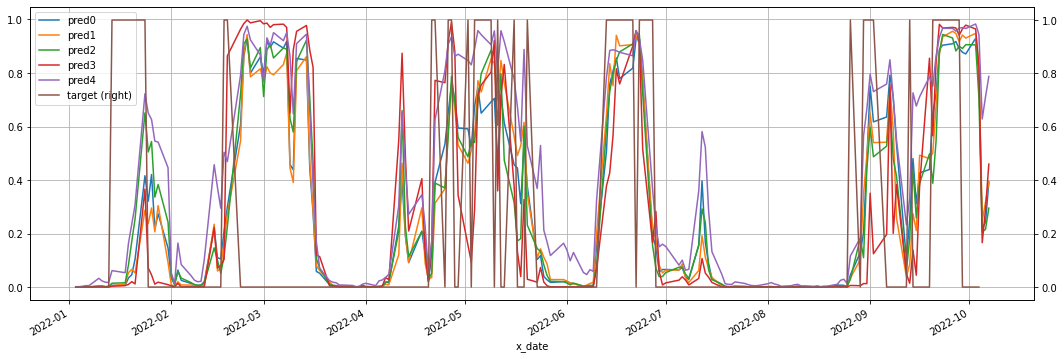

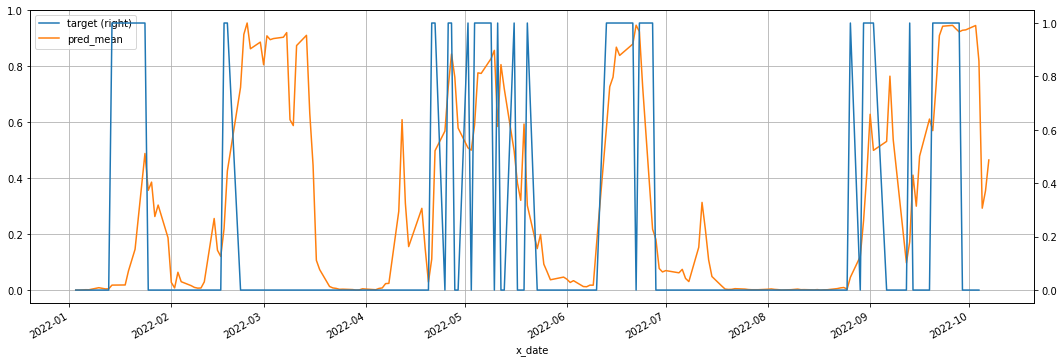

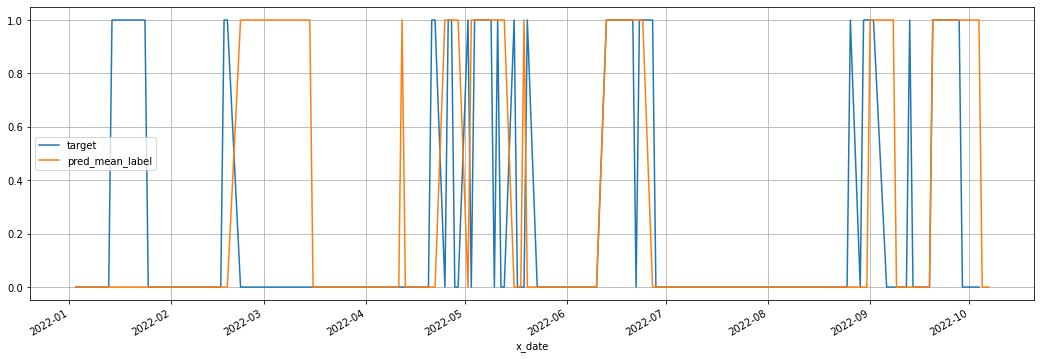

In [59]:
df_pred[pred_cols+['target']].plot(figsize=(18, 6), secondary_y=['target'], grid=True)
df_pred[['target', 'pred_mean',]].plot(figsize=(18, 6), secondary_y=['target'], grid=True)
df_pred[['target', 'pred_mean_label']].plot(figsize=(18, 6),  grid=True)

In [60]:
df_pred.tail(10)

,target,pred0,pred1,pred2,pred3,pred4,pred_mean,pred_mean_label
x_date,,,,,,,,
2022-09-26,1.00,0.91,0.96,0.93,0.97,0.97,0.95,1
2022-09-27,1.00,0.92,0.95,0.88,0.97,0.96,0.93,1
2022-09-28,1.00,0.89,0.92,0.90,0.94,0.97,0.92,1
2022-09-29,0.00,0.88,0.94,0.89,0.96,0.97,0.93,1
2022-09-30,0.00,0.87,0.93,0.91,0.98,0.97,0.93,1
2022-10-03,0.00,0.93,0.95,0.91,0.96,0.98,0.95,1
2022-10-04,0.00,0.79,0.83,0.71,0.82,0.94,0.82,1
2022-10-05,NaN,0.22,0.25,0.21,0.17,0.63,0.29,0
2022-10-06,NaN,0.24,0.32,0.22,0.29,0.71,0.36,0
